In [1]:
from math import *
import matplotlib.pyplot as plt

In [2]:
def EucDist(X, Y):
    # X and Y are lists with coordinates of points in arbitrary dimensions
    return sqrt(sum([ (x-y)**2 for x,y in zip(X,Y) ]))

In [3]:
def sd(data):
    n = len(data)

    if n <= 1:
        return 0.0

    mean, sd = avg(data), 0.0

    # calculate stan. dev.
    for el in data:
        sd += (float(el) - mean)**2
    sd = sqrt(sd / float(n-1))

    return sd

def avg(ls):
    n, mean = len(ls), 0.0

    if n <= 1:
        return ls[0]

    # calculate average
    for el in ls:
        mean = mean + float(el)
    mean = mean / float(n)

    return mean


In [4]:
def GetAlignedWindows(M, N, m_pt, n_pt, window):
    
    # for the given point in each set of points
    # extract the window of interest
    # align the sequence of points
    # calculate and return the distance between aligned windows
    
    # get the window of points for M
    M_pts = [ m_pt + v for v in range(-window,window+1)]
    for i,v in enumerate(M_pts):
        if v < 0:
            M_pts[i] += len(M)
        elif v >= len(M):
            M_pts[i] -= len(M)
    
    M_window = { pt:{'x':M[list(M.keys())[pt]]['x'],
                     'y':M[list(M.keys())[pt]]['y']} for pt in M_pts }

    # find the shift needed to align the given points
    # 2-dimensional for now
    x_shift = M[list(M.keys())[m_pt]]['x'] - N[list(N.keys())[n_pt]]['x']
    y_shift = M[list(M.keys())[m_pt]]['y'] - N[list(N.keys())[n_pt]]['y']
    
    # get window of points for N and apply shift
    N_pts = [ n_pt + v for v in range(-window,window+1)]
    for i,v in enumerate(N_pts):
        if v < 0:
            N_pts[i] += len(N)
        elif v >= len(N):
            N_pts[i] -= len(N)
    
    N_window = { pt:{'x':N[list(N.keys())[pt]]['x'] + x_shift,
                     'y':N[list(N.keys())[pt]]['y'] + y_shift} for pt in N_pts} 

    return M_window, N_window
    

In [5]:
def AlignScore(M, N, m_pt, n_pt, window):
    
    # get the aligned windows
    M_window, N_window = GetAlignedWindows(M, N, m_pt, n_pt, window)
    
    # compute similarity score 
    # similarity in this case is the sum of Euclidean distances 
    # between matched points
    sum = 0.0
    for M_pt, N_pt in zip(M_window.keys(), N_window.keys()):
        sum += EucDist( [ M_window[M_pt]['x'], M_window[M_pt]['y'] ],
                        [ N_window[N_pt]['x'], N_window[N_pt]['y'] ])
    return sqrt(sum)

In [6]:
def AlignPieces_Euclid(M, N, mode = 'max distance', window=10, 
             cutoff = 100, distr_score = False, avg = 25, sd = 5): 
      
    
    # places to store maximum score and which position
    mx = 0.0
    mx_M = 0
    mx_N = 0
    
    # Create suffix table
    SuffTable = [[0 for k in range(len(N)+1)] for l in range(len(M)+1)] 
      
    # Build suffix table
    cutoff_multiplier = 2.0 # penalty for extended ranges outside cutoff
    for i in range(len(M) + 1): 
        for j in range(len(N) + 1): 
            if (i == 0 or j == 0): 
                SuffTable[i][j] = 0
            else:
                d = AlignScore(M, N, i-1, j-1, window)
                if mode == 'max distance': #return actual distances - used to establish cutoff
                    SuffTable[i][j] = d
                elif mode == 'min distance': #return actual distances - used to establish cutoff
                    SuffTable[i][j] = 1/d
                elif mode == 'NW_align': # Needleman-Wunsch - global alignment
                    if d < cutoff: 
                        SuffTable[i][j] = SuffTable[i-1][j-1] + 1
                    else: #ignore distances above cutoff
                        SuffTable[i][j] = SuffTable[i-1][j-1] - 1
                elif mode == 'SW align': #Smith-Waterman - local alignment
                    if distr_score:
                        qtile = (d-avg)/sd
                        if qtile > 0:
                            SuffTable[i][j] = SuffTable[i-1][j-1] - qtile #* #cutoff_multiplier
                            cutoff_multiplier *= 2.0
                        else:
                            SuffTable[i][j] = SuffTable[i-1][j-1] - qtile
                    else:
                        if d < cutoff: # small distance improve our score
                            SuffTable[i][j] = SuffTable[i-1][j-1] + 1
                            cutoff_multiplier = 1
                        else: #large distances degrade our score
                            SuffTable[i][j] = SuffTable[i-1][j-1] - cutoff_multiplier
                            #cutoff_multiplier *= 2.0
                    SuffTable[i][j] = max(0,SuffTable[i][j])

                if SuffTable[i][j] > mx:
                    mx = SuffTable[i][j]
                    mx_M = i
                    mx_N = j
    
    # determine the length of the best scoring window
    length = 0
    for length in range( 1, min(mx_M,mx_N) ):
        if SuffTable[mx_M-length][mx_N-length] == 0:
            break

    return SuffTable, mx, mx_M, mx_N, length-1

In [7]:
# Load pieces
C_order_pts = {}
C_dists = []
fin = open('C_dists.csv', 'r')
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    C_order_pts[i] = int(tok[0])-1 # inferring order from distance list - adjust for base 0
    C_dists.append( [float(v) for v in tok[1:]] )
fin.close()

N_order_pts = {}
N_dists = []
fin = open('N_dists.csv', 'r')
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    N_order_pts[i] = int(tok[0])-1 # inferring order from distance list - adjust for base 0
    N_dists.append( [float(v) for v in tok[1:]] )
fin.close()

NW_order_pts = {}
NW_dists = []
fin = open('NW_dists.csv', 'r')
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    NW_order_pts[i] = int(tok[0])-1 # inferring order from distance list - adjust for base 0
    NW_dists.append( [float(v) for v in tok[1:]] )
fin.close()

S_order_pts = {}
S_dists = []
fin = open('S_dists.csv', 'r')
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    S_order_pts[i] = int(tok[0])-1 # inferring order from distance list - adjust for base 0
    S_dists.append( [float(v) for v in tok[1:]] )
fin.close()

SW_order_pts = {}
SW_dists = []
fin = open('SW_dists.csv', 'r')
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    SW_order_pts[i] = int(tok[0])-1 # inferring order from distance list - adjust for base 0
    SW_dists.append( [float(v) for v in tok[1:]] )
fin.close()

SE_order_pts = {}
SE_dists = []
fin = open('SE_dists.csv', 'r')
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    SE_order_pts[i] = int(tok[0])-1 # inferring order from distance list - adjust for base 0
    SE_dists.append( [float(v) for v in tok[1:]] )
fin.close()

W_order_pts = {}
W_dists = []
fin = open('W_dists.csv', 'r')
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    W_order_pts[i] = int(tok[0])-1 # inferring order from distance list - adjust for base 0
    W_dists.append( [float(v) for v in tok[1:]] )
fin.close()

E_order_pts = {}
E_dists = []
fin = open('E_dists.csv', 'r')
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    E_order_pts[i] = int(tok[0])-1 # inferring order from distance list - adjust for base 0
    E_dists.append( [float(v) for v in tok[1:]] )
fin.close()

C_pts = {}
fin = open('C_border_ordered.csv')
h = fin.readline()
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    C_pts[i] = {}
    C_pts[i]['x'] = int(tok[0])
    C_pts[i]['y'] = int(tok[1])
fin.close()

N_pts = {}
fin = open('N_border_ordered.csv')
h = fin.readline()
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    N_pts[i] = {}
    N_pts[i]['x'] = int(tok[0])
    N_pts[i]['y'] = int(tok[1])
fin.close()

NW_pts = {}
fin = open('NW_border_ordered.csv')
h = fin.readline()
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    NW_pts[i] = {}
    NW_pts[i]['x'] = int(tok[0])
    NW_pts[i]['y'] = int(tok[1])
fin.close()

S_pts = {}
fin = open('S_border_ordered.csv')
h = fin.readline()
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    S_pts[i] = {}
    S_pts[i]['x'] = int(tok[0])
    S_pts[i]['y'] = int(tok[1])
fin.close()

SW_pts = {}
fin = open('SW_border_ordered.csv')
h = fin.readline()
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    SW_pts[i] = {}
    SW_pts[i]['x'] = int(tok[0])
    SW_pts[i]['y'] = int(tok[1])
fin.close()

SE_pts = {}
fin = open('SW_border_ordered.csv')
h = fin.readline()
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    SE_pts[i] = {}
    SE_pts[i]['x'] = int(tok[0])
    SE_pts[i]['y'] = int(tok[1])
fin.close()

W_pts = {}
fin = open('W_border_ordered.csv')
h = fin.readline()
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    W_pts[i] = {}
    W_pts[i]['x'] = int(tok[0])
    W_pts[i]['y'] = int(tok[1])
fin.close()

E_pts = {}
fin = open('E_border_ordered.csv')
h = fin.readline()
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    E_pts[i] = {}
    E_pts[i]['x'] = int(tok[0])
    E_pts[i]['y'] = int(tok[1])
fin.close()

94.5464391390662 101 197 29


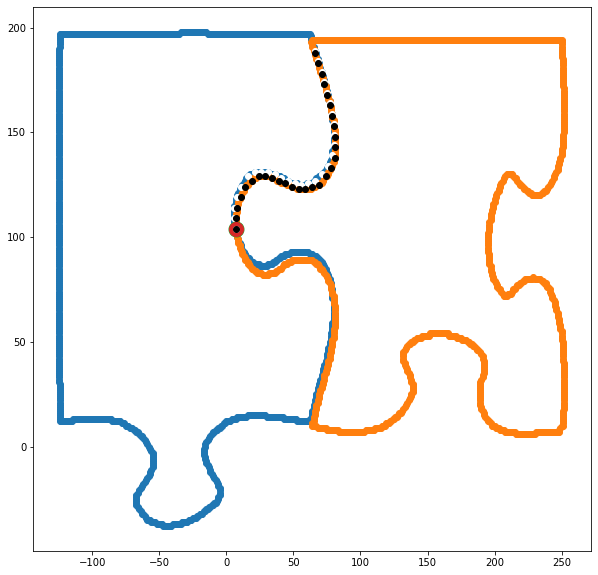

In [8]:
%matplotlib inline

#query piece
Q_pts = SW_pts
Q_order_pts = SW_order_pts
Q_sample = { pt:Q_pts[pt] for i,pt in Q_order_pts.items() }

#target piece - reverse order of sample
T_pts = S_pts
T_order_pts = S_order_pts
T_sample = { i:T_pts[T_order_pts[i]] for i in list(T_order_pts.keys())[::-1] }

# avg and sd are derived from SuffTable from a run of 'mode = 'max distance' 
SuffTable, mx, mx_q, mx_t, length = AlignPieces_Euclid(Q_sample, T_sample, 
                                              mode = 'SW align', window = 10, cutoff = 17.4,
                                              distr_score = True, avg = 25, sd = 5)
print(mx, mx_q, mx_t, length)

#find the best matched point - this is the end of the best match window
Q_pt = Q_order_pts[list(Q_order_pts.keys())[mx_q-1]]
T_pt = T_order_pts[list(T_order_pts.keys())[::-1][mx_t-1]] 

# find x,y shift to align pieces
Q_xshift = Q_pts[Q_pt]['x'] - T_pts[T_pt]['x']
Q_yshift = Q_pts[Q_pt]['y'] - T_pts[T_pt]['y'] 

plt.figure(figsize = [10,10])
plt.scatter( [Q_pts[k]['x'] - Q_xshift for k,v in Q_pts.items() ],
             [Q_pts[k]['y'] - Q_yshift for k,v in Q_pts.items() ])
plt.scatter( [T_pts[k]['x'] for k,v in T_pts.items() ],
             [T_pts[k]['y'] for k,v in T_pts.items() ])

plt.plot( [Q_pts[Q_pt]['x'] - Q_xshift, T_pts[T_pt]['x']],
          [Q_pts[Q_pt]['y'] - Q_yshift, T_pts[T_pt]['y']],
        linewidth = 3)

# show best matched points - second will overplot first due to alignment
plt.scatter( Q_pts[Q_pt]['x'] - Q_xshift, Q_pts[Q_pt]['y'] - Q_yshift, s=225)
plt.scatter( T_pts[T_pt]['x'], T_pts[T_pt]['y'], s=196 ) 

# show similarity window
# the black and white points repsent the points in the positive scoring diagonal
# of the suffix table starting at the maximum scoring point
# these points are the best locally aligned points
Q_window = [Q_order_pts[p] for p in list(Q_order_pts.keys())[ max((mx_q-length),0):(mx_q)] ]
plt.scatter( [Q_pts[p]['x'] - Q_xshift for p in Q_window],
             [Q_pts[p]['y'] - Q_yshift for p in Q_window], c = 'white' )
T_window = [T_order_pts[p] for p in list(T_order_pts.keys())[::-1][(mx_t-length):(mx_t)] ]
plt.scatter( [T_pts[p]['x'] for p in T_window],
             [T_pts[p]['y'] for p in T_window], c = 'black' )

In [ ]:
v = []
for i in range(1,len(SuffTable)):
    for j in range(1,len(SuffTable[i])):
        v.append(SuffTable[i][j])
        
v.sort()

l = len(v)
print(min(v), v[int(l*.1)], v[int(l*.2)], v[int(l*.3)], v[int(l*.4)], v[int(l*.5)], 
              v[int(l*.6)], v[int(l*.7)], v[int(l*.8)], v[int(l*.9)], max(v))
print(avg(v), sd(v))
plt.hist(v)

In [98]:
fout = open('CvsS_MaxDist_Euclid.csv', 'w')
for r in SuffTable:
    fout.write(','.join([ str(v) for v in r ]) + '\n')
fout.close()